In [ ]:
##Streamlit - Desempenho de Vendas

In [2]:
import os
import sys

# Pega o diretório atual do notebook
notebook_dir = os.getcwd()

# Pega o diretório-raiz do projeto (um nível acima)
project_root = os.path.dirname(notebook_dir)

# Adiciona o diretório-raiz ao caminho de busca do Python
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Caminho do projeto adicionado ao sys.path: {project_root}")

Caminho do projeto adicionado ao sys.path: c:\Users\wagne\IntelliJ Idea-Workspace\Desempenho-de-vendas


In [3]:
# 1 - imports e checagem de versão
import pandas as pd
import numpy as np
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

print("Python:", sys.version.splitlines()[0])
print("scikit-learn:", sklearn.__version__)


Python: 3.13.6 (tags/v3.13.6:4e66535, Aug  6 2025, 14:36:00) [MSC v.1944 64 bit (AMD64)]
scikit-learn: 1.7.1


In [4]:
# 2. Carregar dados e verificação inicial
df = pd.read_csv("C:/Users/wagne/IntelliJ Idea-Workspace/Desempenho-de-vendas/Train.csv")

print("Shape:", df.shape)
print("\nNulos por coluna:")
print(df.isnull().sum())

print("\nValor únicos / exemplo de colunas importantes:")
print(df['Outlet_Type'].value_counts(dropna=False))
print(df['Outlet_Size'].value_counts(dropna=False))
print(df['Item_Visibility'].describe())

Shape: (8523, 12)

Nulos por coluna:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Valor únicos / exemplo de colunas importantes:
Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64
Outlet_Size
Medium    2793
NaN       2410
Small     2388
High       932
Name: count, dtype: int64
count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64


In [5]:
# Preparar as variáveis de features e labels
features = df[['Item_Weight', 'Item_Visibility', 'Item_MRP']].copy()
labels_linear = df['Item_Outlet_Sales'].copy()

# Para a regressão logística, você precisa de um rótulo de classificação
# Criando um rótulo para a visibilidade (exemplo)
df['Is_High_Visibility'] = (df['Item_Visibility'] > df['Item_Visibility'].median()).astype(int)
labels_logistic = df['Is_High_Visibility'].copy()

# Tratar valores nulos nas features
features = features.fillna(features.mean(numeric_only=True))

print("✅ Dados de features e labels preparados.")

✅ Dados de features e labels preparados.


In [6]:
#3 - limpar casos críticos
# 1) Se houver linhas sem Item_Visibility, eliminamos (não dá para criar y)
initial_len = len(df)
df = df.dropna(subset=['Item_Visibility'])
print(f"Linhas removidas por ausência de Item_Visibility: {initial_len - len(df)}")

# 2) Se Outlet_Type for NaN, preencher com 'Unknown' (evita problemas no groupby)
df['Outlet_Type'] = df['Outlet_Type'].fillna('Unknown')

# 3) Conferir novamente
print("\nNulos por coluna (após limpeza):")
print(df.isnull().sum())


Linhas removidas por ausência de Item_Visibility: 0

Nulos por coluna (após limpeza):
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Is_High_Visibility              0
dtype: int64


In [7]:
#4 - criar Item_Visibility_Bin
median_vis = df['Item_Visibility'].median()
df['Item_Visibility_Bin'] = (df['Item_Visibility'] > median_vis).astype(int)

print("Mediana de Item_Visibility:", median_vis)
print("\nDistribuição da nova variável alvo:")
print(df['Item_Visibility_Bin'].value_counts(normalize=True))

Mediana de Item_Visibility: 0.053930934

Distribuição da nova variável alvo:
Item_Visibility_Bin
0    0.500059
1    0.499941
Name: proportion, dtype: float64


In [8]:
# 5 - imputação condicional para Outlet_Size
def fill_outlet_size(group):
    mode_vals = group.mode()
    if not mode_vals.empty:
        mode_val = mode_vals.iloc[0]
    else:
        mode_val = 'Medium'  # fallback
    return group.fillna(mode_val)

df['Outlet_Size'] = df.groupby('Outlet_Type')['Outlet_Size'].transform(fill_outlet_size)

# Se ainda restarem NaNs (por segurança), preencher com 'Unknown'
df['Outlet_Size'].fillna('Unknown', inplace=True)

print("Contagem Outlet_Size após imputação:")
print(df['Outlet_Size'].value_counts(dropna=False))


Contagem Outlet_Size após imputação:
Outlet_Size
Small     4798
Medium    2793
High       932
Name: count, dtype: int64


C:\Users\wagne\AppData\Local\Temp\ipykernel_20232\372904765.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Outlet_Size'].fillna('Unknown', inplace=True)


In [9]:
#6 - definir X e y e garantir que não existam nulos em X
X = df[['Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type']].copy()
y = df['Item_Visibility_Bin'].copy()

# Garantir que não existam NaNs nas features categóricas (apenas por segurança)
X = X.fillna('Unknown')

print("Exemplo X:")
display(X.head())
print("\nDistribuição y:")
print(y.value_counts())


Exemplo X:


,Outlet_Type,Outlet_Size,Outlet_Location_Type
0,Supermarket Type1,Medium,Tier 1
1,Supermarket Type2,Medium,Tier 3
2,Supermarket Type1,Medium,Tier 1
3,Grocery Store,Small,Tier 3
4,Supermarket Type1,High,Tier 3



Distribuição y:
Item_Visibility_Bin
0    4262
1    4261
Name: count, dtype: int64


In [10]:
# 7 - One-Hot Encoding (tratando diferenças de versão do sklearn)
try:
    # sklearn >= 1.2 usa sparse_output
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
except TypeError:
    # sklearn < 1.2
    encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

X_encoded = encoder.fit_transform(X)  # numpy array
feature_names = encoder.get_feature_names_out(X.columns)  # nomes das colunas after OHE
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

print("Dimensões X_encoded:", X_encoded_df.shape)
X_encoded_df.head()


Dimensões X_encoded: (8523, 7)


,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Cell 8 - dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.20, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)

Tamanho treino: (6818, 7)
Tamanho teste: (1705, 7)


In [12]:
# Cell 9 - treinar modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Acurácia: 0.5507331378299121

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.92      0.67       853
           1       0.69      0.18      0.29       852

    accuracy                           0.55      1705
   macro avg       0.61      0.55      0.48      1705
weighted avg       0.61      0.55      0.48      1705

ROC AUC: 0.552590553087969


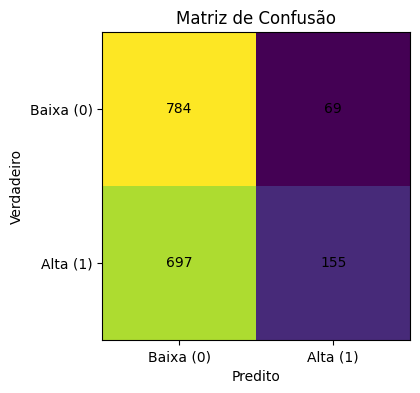

In [13]:
# Cell 10 - avaliação
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probabilidade da classe 1

print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusão (plot simples com matplotlib)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
ax.imshow(cm, interpolation='nearest')
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Baixa (0)', 'Alta (1)'])
ax.set_yticklabels(['Baixa (0)', 'Alta (1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha="center", va="center")
plt.show()


In [14]:
# Cell 11 - interpretação dos coeficientes
coefs = model.coef_[0]  # vetor 1 x n_features
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'odds_ratio': np.exp(coefs)
}).sort_values(by='coef', key=lambda s: np.abs(s), ascending=False)

display(coef_df.head(30))

,feature,coef,odds_ratio
0,Outlet_Type_Supermarket Type1,-0.960612,0.382659
2,Outlet_Type_Supermarket Type3,-0.851417,0.426810
1,Outlet_Type_Supermarket Type2,-0.794927,0.451614
6,Outlet_Location_Type_Tier 3,-0.129649,0.878404
3,Outlet_Size_Medium,-0.095259,0.909138
4,Outlet_Size_Small,-0.038906,0.961841
5,Outlet_Location_Type_Tier 2,0.009888,1.009937


In [15]:
# Cell 12 - salvar modelo e encoder
import joblib
joblib.dump(model, 'logreg_visibility_model.joblib')
joblib.dump(encoder, 'onehot_encoder.joblib')
print("Modelos salvos: logreg_visibility_model.joblib, onehot_encoder.joblib")


Modelos salvos: logreg_visibility_model.joblib, onehot_encoder.joblib


In [16]:
# Importa as funções que agora existem
from core.model_utils import train_linear_model, train_logistic_model

# Treinar regressão linear (previsão de vendas)
linear_model = train_linear_model(features, labels_linear)
print("Modelo Linear treinado:", linear_model)

# Treinar regressão logística (classificação visibilidade)
X_logistic = df[['Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type']].copy()
log_model = train_logistic_model(X_logistic, labels_logistic)
print("Modelo Logístico treinado:", log_model)

✅ Linear Regression salvo em model/
Modelo Linear treinado: LinearRegression()
✅ Logistic Regression e encoder salvos em model/
Modelo Logístico treinado: LogisticRegression(max_iter=1000)
